In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel
import easyocr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

2026-02-28 13:13:27.880548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772284408.043527      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772284408.088817      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772284408.446709      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772284408.446737      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772284408.446740      55 computation_placer.cc:177] computation placer alr

In [2]:
import pandas as pd



CSV_PATH = "/kaggle/input/sth-malyalam-datasets/train_malayalam_ocr.csv"

df1 = pd.read_csv(CSV_PATH)
df2=pd.read_excel('/kaggle/input/malyalam-trainwithlabel/Malayalam_Train_label.xlsx')
df=pd.merge(df1,df2, on='meme_id', how='inner')
print(df.shape)
df.head()

print(df.shape)
df.head()

(500, 4)
(500, 4)


,meme_id,ml_text_clean,Level 1,Level 2
0,1,1 . ടം ആജ്‌\nര്‍ പ പ ദ്ദ; ടി ഗ്യ ഷ്‌ കാടോ ലാ\n...,TROLL/ OPPOSE,Intersection
1,10,റും ര.\n7 ല്‍ റ ന പ\n൫9൭൭2 ന മി\nടം ന്തര ഞന\n1...,TROLL/ OPPOSE,Against individual person
2,101,വി\n\n4 ിജിിര്തിട\n\n(95 0790൫5 രി:\n\n1) [രിത...,TROLL/ OPPOSE,Against party
3,102,ടട (ധ്യ 7 ഉ ണ്ണ ു\nടം; റ്റി നിം യ; ചി റി ൧\nപം...,TROLL/ OPPOSE,Against individual person
4,104,| ആആ്ഞ്ഞ്ഞ്ഞ്തംത്ത്്തഴ് [|\n)൭(൫70പയല്നുന്ന്ര!...,TROLL/ OPPOSE,Against individual person


In [3]:
def Level1_MAP(label):
    
    if "TROLL/ OPPOSE" in label:
        return 1
    elif "SUPPORT" in label:
        return 0

    else :
        return 'NaN'


def map_level2(label):
    

    if "person" in label:
        return 0
    elif "party" in label:
        return 1
    elif "Intersection" in label:
        return 2
    else:
        return -1

In [4]:
df['label1']=df['Level 1'].map(Level1_MAP)
df['label2']=df["Level 2"].apply(map_level2)

print("Train examples:", len(df))

df.head()

Train examples: 500


,meme_id,ml_text_clean,Level 1,Level 2,label1,label2
0,1,1 . ടം ആജ്‌\nര്‍ പ പ ദ്ദ; ടി ഗ്യ ഷ്‌ കാടോ ലാ\n...,TROLL/ OPPOSE,Intersection,1,2
1,10,റും ര.\n7 ല്‍ റ ന പ\n൫9൭൭2 ന മി\nടം ന്തര ഞന\n1...,TROLL/ OPPOSE,Against individual person,1,0
2,101,വി\n\n4 ിജിിര്തിട\n\n(95 0790൫5 രി:\n\n1) [രിത...,TROLL/ OPPOSE,Against party,1,1
3,102,ടട (ധ്യ 7 ഉ ണ്ണ ു\nടം; റ്റി നിം യ; ചി റി ൧\nപം...,TROLL/ OPPOSE,Against individual person,1,0
4,104,| ആആ്ഞ്ഞ്ഞ്ഞ്തംത്ത്്തഴ് [|\n)൭(൫70പയല്നുന്ന്ര!...,TROLL/ OPPOSE,Against individual person,1,0


In [5]:
df['Level 1'].value_counts()

Level 1
TROLL/ OPPOSE    477
SUPPORT           23
Name: count, dtype: int64

In [6]:
df['Level 2'].value_counts()

Level 2
Against individual person        315
Against party                    110
Intersection                      53
Support for individual person     12
Support for party                 10
Name: count, dtype: int64

In [7]:
test_df1=pd.read_csv('/kaggle/input/test-malaylam/test_malayalam_ocr (1).csv')
test_df2=pd.read_excel('/kaggle/input/malyalam-test-csv/Malayalam_Test_label.xlsx')
test_df=pd.merge(test_df1, test_df2, on='meme_id', how='inner')
test_df.head()


,meme_id,ml_text_clean,Level 1,Level 2
0,100,1111001000\nകില്‍ ത്ത്‌ ഗള്‍ കം ക ്ന\nറ ഥി വ 4...,NaN,NaN
1,103,) ' 55 ഹ്ന... ടാം പി\nടാ ടം ത്തത്‌\n; ക ത ന ക ...,NaN,NaN
2,106,1.\nവ ്ു വ ി . & യ ക\nലി സ്സ [ പ്ര ി ബ്ല യ നടന...,NaN,NaN
3,107,ന 2011)0200)0/7/11001/01\nയിട്ടു ദിനം.\nയി ാ\n...,NaN,NaN
4,122,യല്ല\nലം ഴു്‌ ലാ ്്‌ ||). [|\n1; റിക ഷ്‌ മി 14...,NaN,NaN


In [8]:
import cv2
import os
import pandas as pd

def load_images_to_dataframe(image_dir):

    data = []


    for file_name in os.listdir(image_dir):
        file_path = os.path.join(image_dir, file_name)
        

        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):

            img = cv2.imread(file_path)
            

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            

            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            

            alpha = 1.2 
            beta = 20   
            img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)


            image_id = int(os.path.splitext(file_name)[0])
            
            # Append image data and file name to the list
            data.append({
                'meme_id': image_id,
                'Image_name': img
            })


    df = pd.DataFrame(data)
    return df

In [9]:
df_train= load_images_to_dataframe('/kaggle/input/full-train-malyalam/Train/Train_images')
df_test = load_images_to_dataframe('/kaggle/input/test-images/Test_images')
train = pd.merge(df, df_train, on='meme_id')
test = pd.merge(test_df, df_test, on='meme_id')

In [10]:
train.head()

,meme_id,ml_text_clean,Level 1,Level 2,label1,label2,Image_name
0,1,1 . ടം ആജ്‌\nര്‍ പ പ ദ്ദ; ടി ഗ്യ ഷ്‌ കാടോ ലാ\n...,TROLL/ OPPOSE,Intersection,1,2,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2..."
1,10,റും ര.\n7 ല്‍ റ ന പ\n൫9൭൭2 ന മി\nടം ന്തര ഞന\n1...,TROLL/ OPPOSE,Against individual person,1,0,"[[[52, 57, 49], [56, 60, 51], [62, 64, 57], [7..."
2,101,വി\n\n4 ിജിിര്തിട\n\n(95 0790൫5 രി:\n\n1) [രിത...,TROLL/ OPPOSE,Against party,1,1,"[[[28, 28, 28], [28, 28, 28], [28, 28, 28], [2..."
3,102,ടട (ധ്യ 7 ഉ ണ്ണ ു\nടം; റ്റി നിം യ; ചി റി ൧\nപം...,TROLL/ OPPOSE,Against individual person,1,0,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2..."
4,104,| ആആ്ഞ്ഞ്ഞ്ഞ്തംത്ത്്തഴ് [|\n)൭(൫70പയല്നുന്ന്ര!...,TROLL/ OPPOSE,Against individual person,1,0,"[[[55, 55, 55], [55, 55, 55], [55, 55, 55], [5..."


In [11]:
!pip install git+https://github.com/indic-transliteration/indic_transliteration_py/@master

  Cloning https://github.com/indic-transliteration/indic_transliteration_py/ (to revision master) to /tmp/pip-req-build-9tgg6dst
  Running command git clone --filter=blob:none --quiet https://github.com/indic-transliteration/indic_transliteration_py/ /tmp/pip-req-build-9tgg6dst
  Resolved https://github.com/indic-transliteration/indic_transliteration_py/ to commit 322e88533190a874743d72853e3991cbd0e1c076
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for indic_transliteration: filename=indic_transliteration-2.3.79-py3-none-any.whl size=164285 sha256=76a3b44de90ae7548ea09d4fdeca985ab2c8ddd1336f0a70710e5dd2ad65779c
  Stored in directory: /tmp/pip-ephem-wheel-cache-4oxn_sq_/wheels/ef/dd/4d/c621f9f27e4ec9e07c73a5614faa96a12a4cc1e94bf05f069b
Successfully built indic_transliteration


In [12]:
def text_preprocessing(text):
    import re
    pattern = re.compile('[@#\/]\S+')
    text = pattern.sub(r'',text)

    pattern = re.compile('\d+')
    text = pattern.sub(r'', text)

    pattern = re.compile(r'https?:\/\/\S+|www\.\S+|ftp:\/\/\S+|mailto:\S+|https?:')

    # First remove URLs
    text = pattern.sub('', text)

    # Remove newline characters (\n) and carriage returns (\r)
    text = text.replace('\n', ' ').replace('\r', '')

    # Remove extra spaces (including multiple spaces)
    text = re.sub(r'\s+', ' ', text).strip()

    import string
    punc = string.punctuation

    text = text.translate(str.maketrans('','',punc))

    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002B50-\U00002B55"  # Stars and other symbols
        "]+",
        flags=re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)

    ml_stopwords = ["ഒരു", "എന്ന്", "മറ്റും", "ഈ", "ഇത്", "എന്ന", "കൊണ്ട്", "എന്നത്", "പല", "ആണ്",
"അല്ലെങ്കിൽ", "അവൻ", "ഞാൻ", "ഉള്ള", "ആ", "ഇവൻ", "എന്നാൽ", "ആദ്യം", "എന്ത്", "നിന്ന്",
"ചില", "എന്റെ", "പോലെ", "വേണ്ടി", "വന്ന്", "ഇതിന്റെ", "അത്", "അവൾ", "തന്നെ", "പലരും",
"എന്നും", "കൂടാതെ", "ശേഷം", "കொண்ட", "ഇരിക്കും", "തന്റെ", "ഉണ്ട്", "സമയം", "എപ്പോഴും",
"അതിന്റെ", "തൻ", "പിന്നീട്", "അവർ", "വരെ", "നീ", "ആയ", "ഇരുന്നു", "ഉണ്ടായിരുന്നു",
"വന്ന", "ഇരുന്ന", "വളരെ", "ഇവിടെ", "മേൽ", "ഒരു", "ഇവ", "ഈ", "കുറിച്ച്", "വരും",
"മറ്റൊരു", "ഇരു", "ഇതിൽ", "പോലെ", "ഇപ്പോൾ", "അവന്റെ", "മാത്രം", "ഈ", "എന്നുള്ള", "മുകളിൽ",
"ശേഷം", "ചേർന്ന", "എനിക്ക്", "ഇനിയും", "ആ ദിവസം", "ഒരേ", "വളരെയേറെ", "അവിടെ",
"പലവിധ", "വിട്ട്", "വലിയ", "അதை", "കുറിച്ചുള്ള", "നിന്റെ", "കൂടുതൽ", "പേര്", "ഇതിനാൽ",
"അവ", "അതേ", "എന്തുകൊണ്ട്", "രീതി", "ആർ", "എന്നതിനെ", "എല്ലാം", "മാത്രമേ", "ഇവിടെ", "അവിടെ",
"സ്ഥലം", "സ്ഥലത്ത്", "അതിൽ", "നാം", "അതിനു", "അതുകൊണ്ട്", "മറ്റു", "ചെറിയ", "വിട്ടു", "ഏത്",
"എന്നുവെച്ച്", "എന്നറിയപ്പെടുന്ന", "എങ്കിലും", "അടുത്ത", "ഇതിനെ", "ഇത്", "എടുക്കാൻ", "ഇതിന്",
"അതുകൊണ്ട്", "ഒഴികെ", "പോലും", "വരെ", "കുറച്ച്", "എനിക്ക്"]
                                                                                              

    
    text_ls = text.split()
    filtered_words = [word for word in text_ls if word not in ml_stopwords]
    # Join the remaining words back into a string
    text = " ".join(filtered_words)

    from indic_transliteration import sanscript
    from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate
    
    
    text = transliterate(text, sanscript.HK, sanscript.TAMIL)


    
    return text

<>:3: SyntaxWarning: invalid escape sequence '\/'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\/'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_55/4251860584.py:3: SyntaxWarning: invalid escape sequence '\/'
  pattern = re.compile('[@#\/]\S+')
/tmp/ipykernel_55/4251860584.py:6: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile('\d+')


In [13]:
train=train.rename(columns={'ml_text_clean': 'text'})
test= test.rename(columns={'ml_text_clean' : 'text'})

In [14]:
train['text'] = train['text'].fillna('').apply(text_preprocessing)
test['text'] = test['text'].fillna('').apply(text_preprocessing)
train['text'] = train['text'].apply(text_preprocessing)
test['text'] = test['text'].apply(text_preprocessing)

In [15]:
train.head()

,meme_id,text,Level 1,Level 2,label1,label2,Image_name
0,1,ടം ആജ്‌ ര്‍ പ പ ദ്ദ ടി ഗ്യ ഷ്‌ കാടോ ലാ പ പ ടം ...,TROLL/ OPPOSE,Intersection,1,2,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2..."
1,10,റും ര ല്‍ റ ന പ ന മി ടം ന്തര ഞന ്‌ പര്‍ ല്‌ ലി...,TROLL/ OPPOSE,Against individual person,1,0,"[[[52, 57, 49], [56, 60, 51], [62, 64, 57], [7..."
2,101,വി ിജിിര്തിട രി രിത്തുതിള്തി സ്‌ ി കസ്യിലാണ്‌ ...,TROLL/ OPPOSE,Against party,1,1,"[[[28, 28, 28], [28, 28, 28], [28, 28, 28], [2..."
3,102,ടട ധ്യ ഉ ണ്ണ ു ടം റ്റി നിം യ ചി റി പം പു ര്‍ ല...,TROLL/ OPPOSE,Against individual person,1,0,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2..."
4,104,ആആ്ഞ്ഞ്ഞ്ഞ്തംത്ത്്തഴ് പയല്നുന്ന്ര ത്ഞ്ത്ൃതന്ത്...,TROLL/ OPPOSE,Against individual person,1,0,"[[[55, 55, 55], [55, 55, 55], [55, 55, 55], [5..."


In [22]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00


In [18]:
print("Distribution for Label1:")
print(train['label1'].value_counts())

# Check counts for label2 (Sub-category)
print("\nDistribution for Label2:")
print(train['label2'].value_counts())

Distribution for Label1:
label1
1    477
0     23
Name: count, dtype: int64

Distribution for Label2:
label2
0    327
1    120
2     53
Name: count, dtype: int64


In [23]:
from PIL import Image
from torchvision import transforms
from deep_translator import GoogleTranslator
import numpy as np
import pandas as pd
import time

augmented_data = []
cnt = 0

# Image augmentation pipeline
img_augmentations = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(10), # Small rotation for variety
])

# Iterate through the Malayalam 'train' dataframe
for idx, row in train.iterrows():
    # Updated Column Names: meme_id, Image_name (pixels), text
    image_data = row['Image_name'] 
    text_content = row['text']
    l1 = row['label1']
    l2 = row['label2']
    meme_id = row['meme_id']

    # --- STRATEGY: Target the extreme minorities ---
    # We augment if Label 1 is 0 OR Label 2 is 2 (Intersection)
    if l1 == 0 or l2 == 2:
        cnt += 1
        if cnt % 5 == 0: print(f"Augmenting Malayalam Minority {cnt}...")

        image_pil = Image.fromarray(np.uint8(image_data))
        
        # We will create 4 variations for each minority row to bridge the gap
        # Languages: English, Tamil, Hindi, Kannada (Dravidian neighbor)
        target_langs = ['en', 'ta', 'hi', 'kn']
        
        for lang in target_langs:
            # 1. Image Transform
            img_aug = np.array(img_augmentations(image_pil))

            # 2. Back-Translation (Malayalam -> Lang -> Malayalam)
            try:
                translated = GoogleTranslator(source='ml', target=lang).translate(text_content)
                time.sleep(0.5) # Safety to avoid 429 Error
                text_aug = GoogleTranslator(source=lang, target='ml').translate(translated)
            except:
                text_aug = text_content # Fallback to original text

            augmented_data.append({
                'meme_id': f"{meme_id}_aug_{lang}",
                'text': text_aug,
                'label1': l1,
                'label2': l2,
                'Image_name': img_aug
            })

# Combine and check
aug_df = pd.DataFrame(augmented_data)
train = pd.concat([train, aug_df], ignore_index=True)

print("\n--- After Augmentation Distribution ---")
print("Label 1:\n", train['label1'].value_counts())
print("Label 2:\n", train['label2'].value_counts())


Augmenting Malayalam Minority 5...
Augmenting Malayalam Minority 10...
Augmenting Malayalam Minority 15...
Augmenting Malayalam Minority 20...
Augmenting Malayalam Minority 25...
Augmenting Malayalam Minority 30...
Augmenting Malayalam Minority 35...
Augmenting Malayalam Minority 40...
Augmenting Malayalam Minority 45...
Augmenting Malayalam Minority 50...
Augmenting Malayalam Minority 55...
Augmenting Malayalam Minority 60...
Augmenting Malayalam Minority 65...
Augmenting Malayalam Minority 70...
Augmenting Malayalam Minority 75...

--- After Augmentation Distribution ---
Label 1:
 label1
1    685
0    115
Name: count, dtype: int64
Label 2:
 label2
0    375
2    265
1    160
Name: count, dtype: int64


In [24]:
# 1. Isolate the "Support" memes that are NOT yet over-augmented
# Focus on those where label2 is 1 or 2 to keep the whole system balanced
target_rows = train[(train['label1'] == 0) & (train['label2'] != 0)].copy()

# 2. If we don't have enough of those, take any label1 == 0
if len(target_rows) < 50:
    target_rows = train[train['label1'] == 0].copy()

more_balanced_data = []
# Use 4 variations per row to add ~400+ samples
final_langs = ['en', 'ta', 'kn', 'te'] 

print(f"Expanding {len(target_rows)} Support memes...")

for idx, row in target_rows.iterrows():
    img_pil = Image.fromarray(np.uint8(row['Image_name'])).convert("RGB")
    
    for lang in final_langs:
        try:
            # Back-translate
            trans = GoogleTranslator(source='ml', target=lang).translate(row['text'])
            time.sleep(0.4)
            text_aug = GoogleTranslator(source=lang, target='ml').translate(trans)
            
            more_balanced_data.append({
                'meme_id': f"{row['meme_id']}_final_{lang}",
                'text': text_aug,
                'label1': 0,
                'label2': row['label2'],
                'Image_name': np.array(img_augmentations(img_pil))
            })
        except:
            continue

# 3. Merge and Check
train = pd.concat([train, pd.DataFrame(more_balanced_data)], ignore_index=True)

print("\n--- FINAL DISTRIBUTION ---")
print("Label 1:\n", train['label1'].value_counts())
print("Label 2:\n", train['label2'].value_counts())


Expanding 55 Support memes...

--- FINAL DISTRIBUTION ---
Label 1:
 label1
1    685
0    335
Name: count, dtype: int64
Label 2:
 label2
0    375
1    360
2    285
Name: count, dtype: int64


In [25]:
# 1. Target a balanced count (around 700 per class)
target_count = 700

# 2. Downsample Label 1 = 0
df_l1_0 = train[train['label1'] == 0]
if len(df_l1_0) > target_count:
    df_l1_0 = df_l1_0.sample(n=target_count, random_state=42)

# 3. Keep all of Label 1 = 1 (since it has 685)
df_l1_1 = train[train['label1'] == 1]

# 4. Combine into a final balanced training set
train_balanced = pd.concat([df_l1_0, df_l1_1]).sample(frac=1, random_state=42).reset_index(drop=True)

print("--- FINAL OPTIMIZED DISTRIBUTION ---")
print(train_balanced['label1'].value_counts())
print(train_balanced['label2'].value_counts())


--- FINAL OPTIMIZED DISTRIBUTION ---
label1
1    685
0    335
Name: count, dtype: int64
label2
0    375
1    360
2    285
Name: count, dtype: int64


In [26]:
print("Distribution for Label1:")
print(train_balanced['label1'].value_counts())
print(train_balanced['label2'].value_counts())


Distribution for Label1:
label1
1    685
0    335
Name: count, dtype: int64
label2
0    375
1    360
2    285
Name: count, dtype: int64


In [27]:
from sklearn.model_selection import train_test_split

# Create a combined key for stratification to keep both labels balanced in the split
stratify_key = train_balanced["label1"].astype(str) + "_" + train_balanced["label2"].astype(str)

# Split the balanced dataframe (85% for training, 15% for validation)
df_train, df_val = train_test_split(
    train_balanced, 
    test_size=0.15, 
    random_state=42, 
    stratify=stratify_key
)

print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")


Training samples: 867
Validation samples: 153


In [26]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel
import easyocr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [29]:
train_balanced=train_balanced.dropna()

In [30]:
import torch
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image

class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Image processing
        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)

        # Return DICTIONARY
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }   


tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')


class MultiModal(nn.Module):
    def __init__(self, bert_model, vit_model, num_classes_l1, num_classes_l2):
        super(MultiModal, self).__init__()
        self.bert_model = bert_model
        self.vit_model = vit_model
        
        # Combined feature size is 768 (BERT) + 768 (ViT) = 1536
        self.classifier_l1 = nn.Linear(1536, num_classes_l1)
        self.classifier_l2 = nn.Linear(1536, num_classes_l2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text features from [CLS] token
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output # Better than mean for BERT-base

        # Vision features from [CLS] token
        vit_output = self.vit_model(pixel_values=pixel_values)
        vision_features = vit_output.pooler_output 

        # Fusion
        combined = torch.cat((text_features, vision_features), dim=1)
        combined = self.dropout(combined)
        
        logits_l1 = self.classifier_l1(combined)
        logits_l2 = self.classifier_l2(combined)
        
        return logits_l1, logits_l2


train_dataset = MultiModalDataset(df_train, tokenizer, feature_extractor)
dev_dataset = MultiModalDataset(df_val, tokenizer, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)


# Initialize
num_l1 = 2 # Troll/Support
num_l2 = 3 # Person/Party
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModal(bert_model, vit_model, num_l1, num_l2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4) # AdamW is better for BERT/ViT


for epoch in range(10): # 10 is usually enough for fine-tuning
  model.train()
  total_loss = 0
  for batch in train_loader:
        # Now batch is a dictionary!
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pixels = batch['pixel_values'].to(device)
        lab1 = batch['label1'].to(device)
        lab2 = batch['label2'].to(device)

        optimizer.zero_grad()
        # Ensure your model forward function returns both out1 and out2
        out1, out2 = model(ids, mask, pixels)
        
        loss = criterion(out1, lab1) + criterion(out2, lab2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
  print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 1.0020
Epoch 2 | Loss: 0.2694
Epoch 3 | Loss: 0.0656
Epoch 4 | Loss: 0.0189
Epoch 5 | Loss: 0.0063
Epoch 6 | Loss: 0.0042
Epoch 7 | Loss: 0.0030
Epoch 8 | Loss: 0.0024
Epoch 9 | Loss: 0.0020
Epoch 10 | Loss: 0.0017


In [30]:
model.eval()
correct_l1 = 0
correct_l2 = 0
total = 0

with torch.no_grad():
    # Use your new val_loader here
    for batch in dev_loader:
        # 1. Access directly by key (No batch[0] or batch[1])
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        
        # 2. Get true labels
        labels_l1 = batch['label1'].to(device)
        labels_l2 = batch['label2'].to(device)

        # 3. Forward pass (returns two outputs)
        outputs_l1, outputs_l2 = model(input_ids, attention_mask, pixel_values)
        
        # 4. Get predictions
        _, predicted_l1 = torch.max(outputs_l1, 1)
        _, predicted_l2 = torch.max(outputs_l2, 1)

        # 5. Update counts
        total += labels_l1.size(0)
        correct_l1 += (predicted_l1 == labels_l1).sum().item()
        correct_l2 += (predicted_l2 == labels_l2).sum().item()

    print(f"Level 1 Accuracy: {100 * correct_l1 / total:.2f}%")
    print(f"Level 2 Accuracy: {100 * correct_l2 / total:.2f}%")


Level 1 Accuracy: 99.35%
Level 2 Accuracy: 89.54%


In [31]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,confusion_matrix
import torch
import numpy as np

# 1. Put model in evaluation mode
model.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam Validation Set...")

with torch.no_grad():
    for batch in dev_loader:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['SUPPORT', 'TROLL/ OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam Validation Set...

📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)
               precision    recall  f1-score   support

      SUPPORT     1.0000    0.9608    0.9800        51
TROLL/ OPPOSE     0.9808    1.0000    0.9903       102

     accuracy                         0.9869       153
    macro avg     0.9904    0.9804    0.9851       153
 weighted avg     0.9872    0.9869    0.9869       153


📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.8060    0.9643    0.8780        56
       party     0.9783    0.8333    0.9000        54
Intersection     0.9500    0.8837    0.9157        43

    accuracy                         0.8954       153
   macro avg     0.9114    0.8938    0.8979       153
weighted avg     0.9073    0.8954    0.8964       153



In [33]:
df_test_labeled=pd.read_excel('/kaggle/input/datasets/anindamajumder118060/malayalam-test-with-labels/Malayalam_Test_label (2).xlsx')

In [37]:
def test_Level1_MAP(label):
    
    if "TROLL/OPPOSE" in label:
        return 1
    elif "Support/Praise" in label:
        return 0

    else :
        return 'NaN'


def test_map_level2(label):
    

    if "person" in label:
        return 0
    elif "party" in label:
        return 1
    elif "Intersection" in label:
        return 2
    else:
        return -1

In [38]:
df_test_labeled['label1']=df_test_labeled['Level 1'].map(test_Level1_MAP)
df_test_labeled['label2']=df_test_labeled["Level 2"].apply(test_map_level2)

print("Train examples:", len(df_test_labeled))

df_test_labeled.head()

Train examples: 100


,Meme_id,Level 1,Level 2,label1,label2
0,2,Support/Praise,Support for individual person,0,0
1,14,TROLL/OPPOSE,Against individual person,1,0
2,15,TROLL/OPPOSE,Against party,1,1
3,21,TROLL/OPPOSE,Against individual person,1,0
4,22,TROLL/OPPOSE,Against individual person,1,0


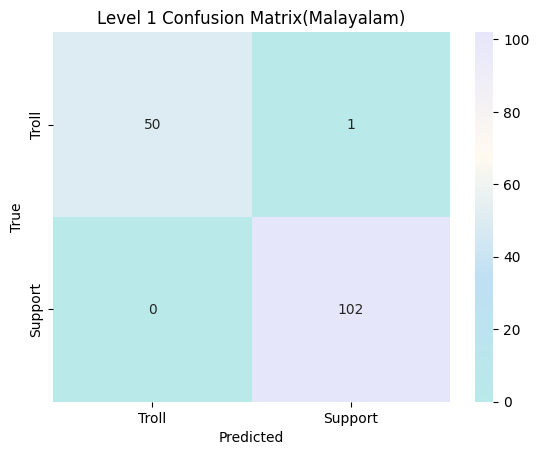

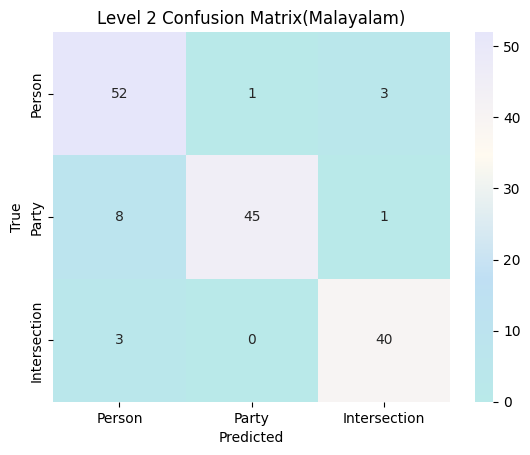

In [37]:
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_pastel",
    ["#B9E9E9", "#BFDFF3", "floralwhite", "#E6E6FA"]
)
# Level 1 Confusion Matrix
cm_l1 = confusion_matrix(l1_true, l1_pred)
# Level 2 Confusion Matrix
cm_l2 = confusion_matrix(l2_true, l2_pred)

def plot_confusion_matrix(cm, title, class_names):
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=custom_cmap,
        cbar=True
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
    plt.show()


# Level 1: Troll / Support
plot_confusion_matrix(cm_l1, "Level 1 Confusion Matrix(Malayalam)", ["Troll", "Support"])

# Level 2: Person / Party
plot_confusion_matrix(cm_l2, "Level 2 Confusion Matrix(Malayalam)", ["Person", "Party", "Intersection"])

In [ ]:
# Check how many unique Tamil sentences are in your validation set
unique_texts_val = df_val['text'].nunique()
total_val = len(df_val)

print(f"Total rows in Validation: {total_val}")
print(f"Unique Tamil sentences: {unique_texts_val}")

if unique_texts_val < total_val:
    print(f"⚠️ Potential Leakage: {total_val - unique_texts_val} rows have repeating text patterns.")

In [ ]:
# 1. Get all unique text strings from the training set
train_texts = set(df_train['text'].unique())

# 2. Filter the validation set to ONLY include text that is NOT in the training set
# This removes all augmented "cousins" of training data
strict_val_df = df_val[~df_val['text'].isin(train_texts)].copy()

print(f"Rows in Strict Validation: {len(strict_val_df)}")

if len(strict_val_df) > 0:
    # 3. Create a new loader for these 'unseen' memes
    strict_val_dataset = MultiModalDataset(strict_val_df, tokenizer, feature_extractor)
    strict_val_loader = DataLoader(strict_val_dataset, batch_size=16, shuffle=False)
    
    # 4. Run your evaluation loop again using 'strict_val_loader'
    # (Use the code we used for the 100% report here)
else:
    print("❌ Error: No unique text found in validation. All val rows are variations of training rows.")

In [ ]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# 1. Create the Strict Dataset and Loader
strict_val_dataset = MultiModalDataset(strict_val_df, tokenizer, feature_extractor)
strict_val_loader = DataLoader(strict_val_dataset, batch_size=16, shuffle=False)

model.eval()
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

with torch.no_grad():
    for batch in strict_val_loader:
        # Move to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass
        out1, out2 = model(ids, mask, pix)
        
        # Get predictions
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# Final Report
print("🔥 --- STRICT VALIDATION RESULTS (0% LEAKAGE) --- 🔥")
print(f"Level 1 F1 (Macro): {f1_score(l1_true, l1_pred, average='macro'):.4f}")
print(classification_report(l1_true, l1_pred, target_names=['Support', 'Troll']))

print("\n" + "="*45 + "\n")
print(f"Level 2 F1 (Macro): {f1_score(l2_true, l2_pred, average='macro'):.4f}")
print(classification_report(l2_true, l2_pred)) 


In [48]:
test
drop_col=['Level 1', 'Level 2']
test.drop(columns=drop_col, axis=1, inplace=True)


In [49]:
test

,meme_id,text,Image_name
0,100,കില്‍ ത്ത്‌ ഗള്‍ കം ക ്ന റ ഥി വ ക്‌ ണാ ലം ടം ്...,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2..."
1,103,ഹ്ന ടാം പി ടാ ടം ത്തത്‌ ക ത ന ക ടൂ ക ന്തു ഹു ട...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,106,വ ്ു വ ി യ ക ലി സ്സ പ്ര ി ബ്ല യ നടന ഥ്‌ റ ലയ ന...,"[[[69, 67, 64], [73, 64, 64], [73, 66, 66], [7..."
3,107,ന യിട്ടു ദിനം യി ാ ട്ട പ നി വിയ റ്‌ ടര രക സമദര...,"[[[176, 115, 38], [175, 114, 38], [172, 111, 3..."
4,122,യല്ല ലം ഴു്‌ ലാ ്്‌ റിക ഷ്‌ മി ഗി കു്‌ ലി ല്ല ...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...
95,65,പ്്ാ്റ്ര യ സ്‌ ന നു ന ക്്‌ക്്മ്തി കക്ഷത്ത്‌ ചി...,"[[[255, 30, 34], [255, 31, 33], [255, 31, 32],..."
96,72,₹ നട ി രം ള്‌ ഴ്‌ ം ി ലം പ്ല ഥ്ട്ബ്ങടയ ജി ടെ അ...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
97,81,ലം ടി ക ക പ്ല ര്‍ ളു തി ം രിത്ത്തിത്ത്തിന്ന്ന്...,"[[[32, 39, 44], [33, 39, 44], [34, 38, 44], [3..."
98,88,രാ നം തട്‌ ക മു ക ടാ ു ച്‌ ി ത്‌ അ നു ം ന ണു ട...,"[[[189, 164, 144], [188, 165, 145], [190, 168,..."


In [43]:
df_test_labeled=df_test_labeled.rename(columns={'Meme_id':'meme_id'})
df_test_labeled

,meme_id,Level 1,Level 2,label1,label2
0,2,Support/Praise,Support for individual person,0,0
1,14,TROLL/OPPOSE,Against individual person,1,0
2,15,TROLL/OPPOSE,Against party,1,1
3,21,TROLL/OPPOSE,Against individual person,1,0
4,22,TROLL/OPPOSE,Against individual person,1,0
...,...,...,...,...,...
95,563,TROLL/OPPOSE,Intersection,1,2
96,584,TROLL/OPPOSE,Against party,1,1
97,586,TROLL/OPPOSE,Against party,1,1
98,595,TROLL/OPPOSE,Against individual person,1,0


In [51]:
merged_test_labeled= pd.merge(test, df_test_labeled, on='meme_id')

In [54]:
merged_test_labeled

,meme_id,text,Image_name,Level 1,Level 2,label1,label2
0,100,കില്‍ ത്ത്‌ ഗള്‍ കം ക ്ന റ ഥി വ ക്‌ ണാ ലം ടം ്...,"[[[20, 20, 20], [20, 20, 20], [20, 20, 20], [2...",TROLL/OPPOSE,Against party,1,1
1,103,ഹ്ന ടാം പി ടാ ടം ത്തത്‌ ക ത ന ക ടൂ ക ന്തു ഹു ട...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",TROLL/OPPOSE,Against individual person,1,0
2,106,വ ്ു വ ി യ ക ലി സ്സ പ്ര ി ബ്ല യ നടന ഥ്‌ റ ലയ ന...,"[[[69, 67, 64], [73, 64, 64], [73, 66, 66], [7...",TROLL/OPPOSE,Against party,1,1
3,107,ന യിട്ടു ദിനം യി ാ ട്ട പ നി വിയ റ്‌ ടര രക സമദര...,"[[[176, 115, 38], [175, 114, 38], [172, 111, 3...",TROLL/OPPOSE,Against individual person,1,0
4,122,യല്ല ലം ഴു്‌ ലാ ്്‌ റിക ഷ്‌ മി ഗി കു്‌ ലി ല്ല ...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",TROLL/OPPOSE,Intersection,1,2
...,...,...,...,...,...,...,...
95,65,പ്്ാ്റ്ര യ സ്‌ ന നു ന ക്്‌ക്്മ്തി കക്ഷത്ത്‌ ചി...,"[[[255, 30, 34], [255, 31, 33], [255, 31, 32],...",TROLL/OPPOSE,Intersection,1,2
96,72,₹ നട ി രം ള്‌ ഴ്‌ ം ി ലം പ്ല ഥ്ട്ബ്ങടയ ജി ടെ അ...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",TROLL/OPPOSE,Intersection,1,2
97,81,ലം ടി ക ക പ്ല ര്‍ ളു തി ം രിത്ത്തിത്ത്തിന്ന്ന്...,"[[[32, 39, 44], [33, 39, 44], [34, 38, 44], [3...",TROLL/OPPOSE,Against individual person,1,0
98,88,രാ നം തട്‌ ക മു ക ടാ ു ച്‌ ി ത്‌ അ നു ം ന ണു ട...,"[[[189, 164, 144], [188, 165, 145], [190, 168,...",TROLL/OPPOSE,Intersection,1,2


In [60]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

class Test_Labeled_Dataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Image processing
        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)

        # Return DICTIONARY
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }   

# 1. Initialize Dataset and Loader
test_dataset_labeled = Test_Labeled_Dataset(merged_test_labeled, tokenizer, feature_extractor)
test_loader_labeled = DataLoader(test_dataset_labeled, batch_size=16)


In [62]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,confusion_matrix
import torch
import numpy as np

# 1. Put model in evaluation mode
model.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam test Set...")

with torch.no_grad():
    for batch in test_loader_labeled:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['Support/Praise', 'TROLL/OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam test Set...

📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)
                precision    recall  f1-score   support

Support/Praise     0.0000    0.0000    0.0000         4
  TROLL/OPPOSE     0.9600    1.0000    0.9796        96

      accuracy                         0.9600       100
     macro avg     0.4800    0.5000    0.4898       100
  weighted avg     0.9216    0.9600    0.9404       100


📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.5862    0.9444    0.7234        54
       party     0.6000    0.1935    0.2927        31
Intersection     0.6667    0.1333    0.2222        15

    accuracy                         0.5900       100
   macro avg     0.6176    0.4238    0.4128       100
weighted avg     0.6026    0.5900    0.5147       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_pastel",
    ["#B9E9E9", "#BFDFF3", "floralwhite", "#E6E6FA"]
)
# Level 1 Confusion Matrix
cm_l1 = confusion_matrix(l1_true, l1_pred)
# Level 2 Confusion Matrix
cm_l2 = confusion_matrix(l2_true, l2_pred)

def plot_confusion_matrix(cm, title, class_names):
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=custom_cmap,
        cbar=True
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
    plt.show()


# Level 1: Troll / Support
plot_confusion_matrix(cm_l1, "Level 1 Confusion Matrix(Malayalam)", ["Support", "Troll"])

# Level 2: Person / Party
plot_confusion_matrix(cm_l2, "Level 2 Confusion Matrix(Malayalam)", ["Person", "Party", "Intersection"])

In [64]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

class TestDataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        # Reset index to ensure safe .loc access
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Use your test dataframe column names
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 

        encoding = self.tokenizer(
            text, 
            padding='max_length', 
            truncation=True, 
            max_length=128, # Match training max_length
            return_tensors='pt'
        )

        image_pil = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        pixel_values = self.feature_extractor(images=image_pil, return_tensors='pt')['pixel_values'].squeeze(0)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values
        }

# 1. Initialize Dataset and Loader
test_dataset = TestDataset(test, tokenizer, feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=16)

# 2. Evaluation Mode
model.eval()

# Lists to store predictions
l1_preds = []
l2_preds = []

print("Starting Inference on Test Data...")
with torch.no_grad():
    for batch in tqdm(test_loader):
        # Access by keys to match updated Dataset
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)

        # Get both Level 1 and Level 2 outputs
        out1, out2 = model(ids, mask, pix)
        
        # Get class indices
        _, pred1 = torch.max(out1, 1)
        _, pred2 = torch.max(out2, 1)

        l1_preds.extend(pred1.cpu().numpy())
        l2_preds.extend(pred2.cpu().numpy())

# 3. Save results to the test dataframe
test['label1_pred'] = l1_preds
test['label2_pred'] = l2_preds

# 4. Export to CSV (assuming your test set has 'Image_id')
predictions_df = pd.DataFrame({
    'meme_id': test['meme_id'],
    'label1_prediction': test['label1_pred'],
    'label2_prediction': test['label2_pred']
})

predictions_df.to_csv('Malyalam_mbert_vit.csv', index=False)
print("Predictions saved")


Starting Inference on Test Data...


100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

Predictions saved


In [36]:
prediction1= pd.read_csv('/kaggle/working/Malyalam_mbert_vit.csv')


In [37]:
def map_meme_labels(row):
    l1 = row['label1_prediction']
    l2 = row['label2_prediction']
    
    # Logic 1: Both are 0
    if l1 == 0 and l2 == 0:
        return "SUPPORT", "Support for individual person"
    
    # Logic 2: label1 is 0 and label2 is 1
    elif l1 == 0 and l2 == 1:
        return "SUPPORT", "Support for party"
    
    # Logic 3: label1 is 1 and label2 is 0
    elif l1 == 1 and l2 == 0:
        return "TROLL/ OPPOSE", "Against individual person"
    
    # Logic 4: Both are 1
    elif l1 == 1 and l2 == 1:
        return "TROLL/OPPOSE", "Against party"

    elif l1==0 and l2==2 :
        return "SUPPORT", "Intersection"

    elif l1==1 and l2==2 :
        return "TROLL/OPPOSE", "Intersection"
    
    # Fallback for any other combinations (optional)
    return "Unknown", "Unknown"

# 1. Apply the logic across the dataframe
# This creates two new columns based on your rules
prediction1[['Level 1', 'Level 2']] = predictions_df.apply(
    lambda row: pd.Series(map_meme_labels(row)), axis=1
)

# 2. Add the Image_name column from your test data
# Assuming 'Image_name_x' contains values like '000.jpg'
prediction1


,meme_id,label1_prediction,label2_prediction,Level 1,Level 2
0,100,1,0,TROLL/ OPPOSE,Against individual person
1,103,1,0,TROLL/ OPPOSE,Against individual person
2,106,1,0,TROLL/ OPPOSE,Against individual person
3,107,1,0,TROLL/ OPPOSE,Against individual person
4,122,1,0,TROLL/ OPPOSE,Against individual person
...,...,...,...,...,...
95,65,1,0,TROLL/ OPPOSE,Against individual person
96,72,1,0,TROLL/ OPPOSE,Against individual person
97,81,1,0,TROLL/ OPPOSE,Against individual person
98,88,1,0,TROLL/ OPPOSE,Against individual person


# ****CLIP+XLM-Roberta

In [65]:
import torch
from transformers import AutoTokenizer, AutoModel, CLIPModel, CLIPProcessor, ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image

class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Image processing
        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        #pixel_values = self.feature_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
        pixel_values = clip_processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
        # Return DICTIONARY
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }   


tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
roberta_model = AutoModel.from_pretrained('xlm-roberta-base')

clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
#efficientnet_model.classifier = nn.Identity()  

class MultiModal(nn.Module):
    def __init__(self, roberta_model, clip_model, num_classes_l1, num_classes_l2):
        super(MultiModal, self).__init__()
        self.roberta_model = roberta_model
        # Use ONLY the vision part of CLIP
        self.clip_vision_model = clip_model.vision_model 
        
        # XLM-R base is 768, CLIP vision-base is 768 -> Total 1536
        self.classifier_l1 = nn.Linear(1536, num_classes_l1)
        self.classifier_l2 = nn.Linear(1536, num_classes_l2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, pixel_values):
        # 1. Text features (XLM-R)
        roberta_output = self.roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        # XLM-R doesn't always have a pooler_output like BERT, 
        # using the mean of hidden states or the first token [CLS/<s>] is safer
        text_features = roberta_output.last_hidden_state[:, 0, :] 

        # 2. Vision features (CLIP Vision)
        # We call .vision_model directly to avoid the text-input requirement
        clip_output = self.clip_vision_model(pixel_values=pixel_values)
        vision_features = clip_output.pooler_output 

        # 3. Fusion
        combined = torch.cat((text_features, vision_features), dim=1)
        combined = self.dropout(combined)
        
        logits_l1 = self.classifier_l1(combined)
        logits_l2 = self.classifier_l2(combined)
        
        return logits_l1, logits_l2


train_dataset = MultiModalDataset(df_train, tokenizer, feature_extractor)
dev_dataset = MultiModalDataset(df_val, tokenizer, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)


# Initialize
num_l1 = 2 # Troll/Support
num_l2 = 3 # Person/Party
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = MultiModal(roberta_model, clip_model, num_l1, num_l2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=2e-5) # AdamW is better for BERT/ViT


for epoch in range(10): # 10 is usually enough for fine-tuning
  model2.train()
  total_loss = 0
  for batch in train_loader:
        # Now batch is a dictionary!
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pixels = batch['pixel_values'].to(device)
        lab1 = batch['label1'].to(device)
        lab2 = batch['label2'].to(device)

        optimizer.zero_grad()
        # Ensure your model forward function returns both out1 and out2
        out1, out2 = model2(ids, mask, pixels)
        
        #loss = criterion(out1, lab1) + criterion(out2, lab2)
        loss1 = criterion(out1, lab1)
        loss2 = criterion(out2, lab2)
        loss = (0.5 * loss1) + (1.5 * loss2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
  print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epoch 1 | Loss: 1.3112
Epoch 2 | Loss: 0.3417
Epoch 3 | Loss: 0.0776
Epoch 4 | Loss: 0.0240
Epoch 5 | Loss: 0.0178
Epoch 6 | Loss: 0.0520
Epoch 7 | Loss: 0.1897
Epoch 8 | Loss: 0.1805
Epoch 9 | Loss: 0.1951
Epoch 10 | Loss: 0.0404


In [66]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import torch
import numpy as np

# 1. Put model in evaluation mode
model2.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam Validation Set...")

with torch.no_grad():
    for batch in dev_loader:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model2(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['SUPPORT', 'TROLL/ OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam Validation Set...

📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)
               precision    recall  f1-score   support

      SUPPORT     0.9796    0.9412    0.9600        51
TROLL/ OPPOSE     0.9712    0.9902    0.9806       102

     accuracy                         0.9739       153
    macro avg     0.9754    0.9657    0.9703       153
 weighted avg     0.9740    0.9739    0.9737       153


📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.7639    0.9821    0.8594        56
       party     1.0000    0.7778    0.8750        54
Intersection     0.9744    0.8837    0.9268        43

    accuracy                         0.8824       153
   macro avg     0.9127    0.8812    0.8871       153
weighted avg     0.9064    0.8824    0.8838       153



In [67]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

class Test_Labeled_Dataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Image processing
        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)

        # Return DICTIONARY
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }   

# 1. Initialize Dataset and Loader
test_dataset_labeled = Test_Labeled_Dataset(merged_test_labeled, tokenizer, feature_extractor)
test_loader_labeled = DataLoader(test_dataset_labeled, batch_size=16)


In [68]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,confusion_matrix
import torch
import numpy as np

# 1. Put model in evaluation mode
model2.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam test Set...")

with torch.no_grad():
    for batch in test_loader_labeled:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model2(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['Support/Praise', 'TROLL/OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam test Set...

📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)
                precision    recall  f1-score   support

Support/Praise     0.0000    0.0000    0.0000         4
  TROLL/OPPOSE     0.9600    1.0000    0.9796        96

      accuracy                         0.9600       100
     macro avg     0.4800    0.5000    0.4898       100
  weighted avg     0.9216    0.9600    0.9404       100


📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.5909    0.9630    0.7324        54
       party     0.5556    0.1613    0.2500        31
Intersection     0.3333    0.0667    0.1111        15

    accuracy                         0.5800       100
   macro avg     0.4933    0.3970    0.3645       100
weighted avg     0.5413    0.5800    0.4897       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# # ****Indic+Resnet

In [69]:
from huggingface_hub import notebook_login
notebook_login() 

In [70]:
import torch
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, image_transform):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=128, return_tensors='pt'
        )

        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        image = self.image_transform(image)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': image,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }


class MultiModal(nn.Module):
    def __init__(self, indicbert_model, resnet_model, num_l1, num_l2):
        super(MultiModal, self).__init__()
        self.indicbert_model = indicbert_model
        self.resnet_model = resnet_model
        
        # 768 (IndicBERT) + 2048 (ResNet50) = 2816
        self.classifier_l1 = nn.Linear(2816, num_l1)
        self.classifier_l2 = nn.Linear(2816, num_l2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text features (Mean Pooling)
        text_out = self.indicbert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        text_features = torch.mean(text_out, dim=1)

        # Image features
        vision_features = self.resnet_model(pixel_values)

        # Fusion
        combined = torch.cat((text_features, vision_features), dim=1)
        combined = self.dropout(combined)
        
        return self.classifier_l1(combined), self.classifier_l2(combined)


tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
indicbert_model = AutoModel.from_pretrained('ai4bharat/indic-bert')

resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Identity() 

model3 = MultiModal(indicbert_model, resnet_model, num_l1=2, num_l2=3).to(device)
optimizer = optim.AdamW(model3.parameters(), lr=2e-5) # Use AdamW and lower LR for BERT
criterion = nn.CrossEntropyLoss()

# Loaders
train_loader = DataLoader(MultiModalDataset(df_train, tokenizer, image_transform), batch_size=16, shuffle=True)
dev_loader = DataLoader(MultiModalDataset(df_val, tokenizer, image_transform), batch_size=16)

for epoch in range(10):
    model3.train()
    total_loss = 0
    for batch in train_loader:
        ids, mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        lab1, lab2 = batch['label1'].to(device), batch['label2'].to(device)

        optimizer.zero_grad()
        out1, out2 = model3(ids, mask, pix)
        
        # Combine losses
        loss = criterion(out1, lab1) + criterion(out2, lab2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")  

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


 11%|█         | 10.9M/97.8M [00:00<00:00, 114MB/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


Epoch 1 | Loss: 1.3038
Epoch 2 | Loss: 0.7649
Epoch 3 | Loss: 0.4638
Epoch 4 | Loss: 0.2642
Epoch 5 | Loss: 0.1396
Epoch 6 | Loss: 0.0867
Epoch 7 | Loss: 0.0569
Epoch 8 | Loss: 0.0570
Epoch 9 | Loss: 0.0435
Epoch 10 | Loss: 0.0319


In [71]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import torch
import numpy as np

# 1. Put model in evaluation mode
model3.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam Validation Set...")

with torch.no_grad():
    for batch in dev_loader:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model3(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['SUPPORT', 'TROLL/ OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam Validation Set...

📊 LEVEL 1: OVERALL SENTIMENT (Troll vs. Support)
               precision    recall  f1-score   support

      SUPPORT     1.0000    0.9608    0.9800        51
TROLL/ OPPOSE     0.9808    1.0000    0.9903       102

     accuracy                         0.9869       153
    macro avg     0.9904    0.9804    0.9851       153
 weighted avg     0.9872    0.9869    0.9869       153


📊 LEVEL 2: TARGET CLASSIFICATION (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.7538    0.8750    0.8099        56
       party     0.8723    0.7593    0.8119        54
Intersection     0.9756    0.9302    0.9524        43

    accuracy                         0.8497       153
   macro avg     0.8673    0.8548    0.8581       153
weighted avg     0.8580    0.8497    0.8506       153



In [72]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

class Test_Labeled_Dataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, 'text'])
        image_arr = self.df.loc[idx, 'Image_name'] 
        l1 = self.df.loc[idx, 'label1']
        l2 = self.df.loc[idx, 'label2']

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Image processing
        image = Image.fromarray(image_arr.astype('uint8')).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)

        # Return DICTIONARY
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'pixel_values': pixel_values,
            'label1': torch.tensor(l1, dtype=torch.long),
            'label2': torch.tensor(l2, dtype=torch.long)
        }   

# 1. Initialize Dataset and Loader
test_dataset_labeled = Test_Labeled_Dataset(merged_test_labeled, tokenizer, feature_extractor)
test_loader_labeled = DataLoader(test_dataset_labeled, batch_size=16)


In [73]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,confusion_matrix
import torch
import numpy as np

# 1. Put model in evaluation mode
model3.eval()

# Storage for ground truth and predictions
l1_true, l1_pred = [], []
l2_true, l2_pred = [], []

print("🚀 Starting Evaluation on Malayalam test Set...")

with torch.no_grad():
    for batch in test_loader_labeled:
        # Move inputs to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        
        # Get true labels
        y1 = batch['label1'].to(device)
        y2 = batch['label2'].to(device)

        # Forward pass (XLM-R + CLIP)
        out1, out2 = model3(ids, mask, pix)
        
        # Get predicted class indices
        _, p1 = torch.max(out1, 1)
        _, p2 = torch.max(out2, 1)

        # Store for report
        l1_true.extend(y1.cpu().numpy())
        l1_pred.extend(p1.cpu().numpy())
        l2_true.extend(y2.cpu().numpy())
        l2_pred.extend(p2.cpu().numpy())

# 2. Define Category Names for clarity
# Adjust these based on your specific Malayalam mapping
target_names_l1 = ['Support/Praise', 'TROLL/OPPOSE']
target_names_l2 = ['person', 'party', 'Intersection']

# 3. Generate and Print Reports
print("\n" + "="*60)
print("📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)")
print("="*60)
print(classification_report(l1_true, l1_pred, target_names=target_names_l1, digits=4))

print("\n" + "="*60)
print("📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)")
print("="*60)
# Use labels=[0, 1, 2] to ensure all classes are included even if zero-support
print(classification_report(l2_true, l2_pred, target_names=target_names_l2, labels=[0, 1, 2], digits=4))


🚀 Starting Evaluation on Malayalam test Set...

📊 LEVEL 1: OVERALL SENTIMENT for Test Data (Troll vs. Support)
                precision    recall  f1-score   support

Support/Praise     0.0000    0.0000    0.0000         4
  TROLL/OPPOSE     0.9600    1.0000    0.9796        96

      accuracy                         0.9600       100
     macro avg     0.4800    0.5000    0.4898       100
  weighted avg     0.9216    0.9600    0.9404       100


📊 LEVEL 2: TARGET CLASSIFICATION for Test Data (Person/Party/Intersection)
              precision    recall  f1-score   support

      person     0.5618    0.9259    0.6993        54
       party     0.4286    0.0968    0.1579        31
Intersection     0.2500    0.0667    0.1053        15

    accuracy                         0.5400       100
   macro avg     0.4135    0.3631    0.3208       100
weighted avg     0.4737    0.5400    0.4424       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
